In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Audio

import librosa
import librosa.display
import librosa.feature
import torch
import torch.nn as nn
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
PATH_TO_DATASET = os.path.join(".", "dataset")

In [4]:
df = pd.read_csv(os.path.join(PATH_TO_DATASET, "UrbanSound8K.csv"))
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [23]:
df.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [24]:
df = df.drop(["fsID", "start", "end", "salience"], axis=1)

df["path_to_audio"] = (
    PATH_TO_DATASET + os.sep + "fold" + df["fold"].astype(str) + os.sep + df["slice_file_name"]
)

In [25]:
df.head()

,slice_file_name,fold,classID,class,path_to_audio
0,100032-3-0-0.wav,5,3,dog_bark,.\dataset\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,5,2,children_playing,.\dataset\fold5\100263-2-0-137.wav


In [26]:
sample_row_idx = 42
sample_file_name = df.at[sample_row_idx, "path_to_audio"]
sample_class = df.at[sample_row_idx, "class"]

print(f"Sample class: {sample_class}")

Audio(sample_file_name)

Sample class: air_conditioner


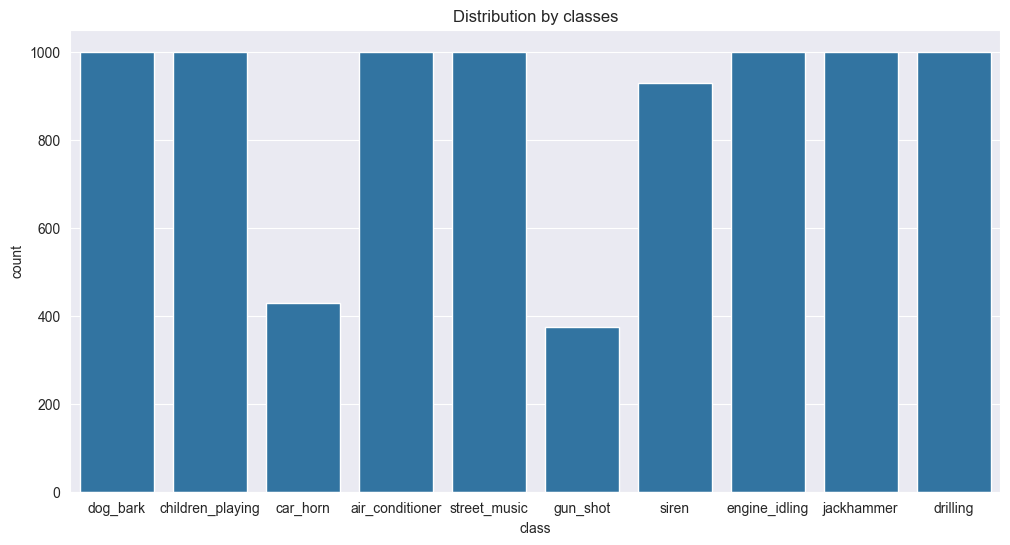

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='class')   # seaborn automatically counts occurrences
plt.title('Distribution by classes')
plt.show()

In [28]:
sample_y, sr = librosa.load(sample_file_name, sr=None)

print(f"Sample rate: {sr} Hz")
print(f"Audio data shape: {sample_y.shape}")

Sample rate: 44100 Hz
Audio data shape: (176400,)


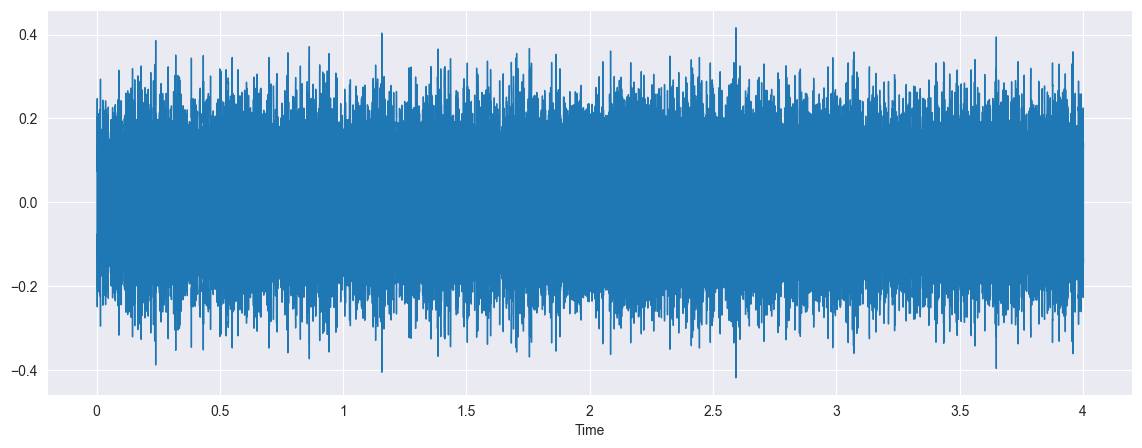

In [29]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample_y, sr=sr)

Text(0, 0.5, 'Frequency (Hz)')

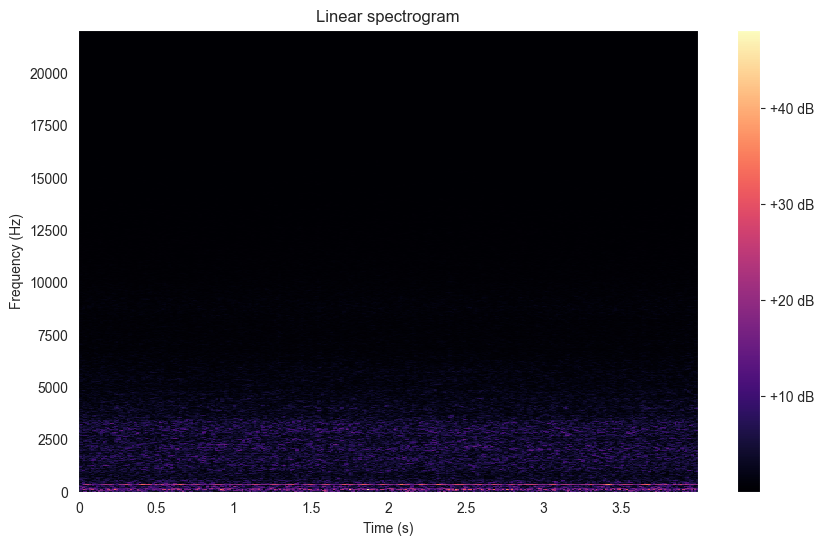

In [30]:
sample_stft = np.abs(librosa.stft(sample_y))
sample_db = librosa.amplitude_to_db(sample_stft, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(sample_stft, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

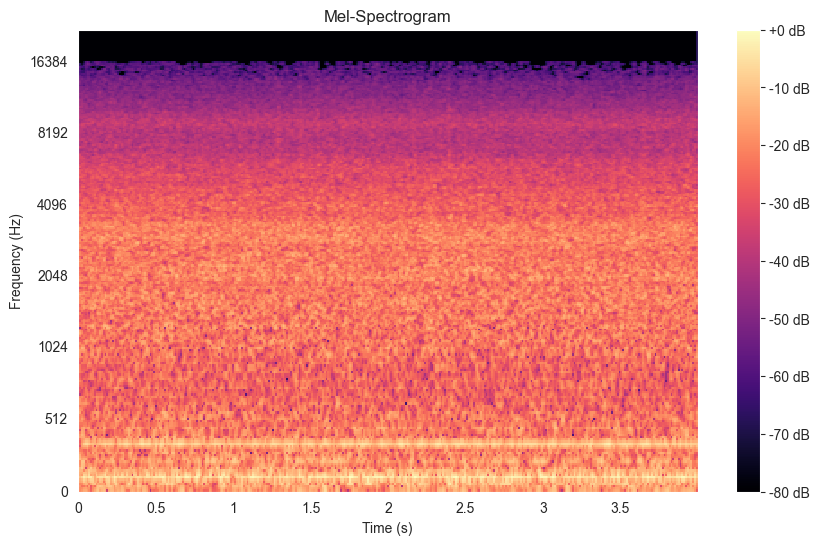

In [31]:
sample_mel_spec = librosa.feature.melspectrogram(y=sample_y, sr=sr, n_mels=256, fmax=sr//2)
mel_spec_db = librosa.power_to_db(sample_mel_spec, ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

MFCC shape for sample: (13, 345)


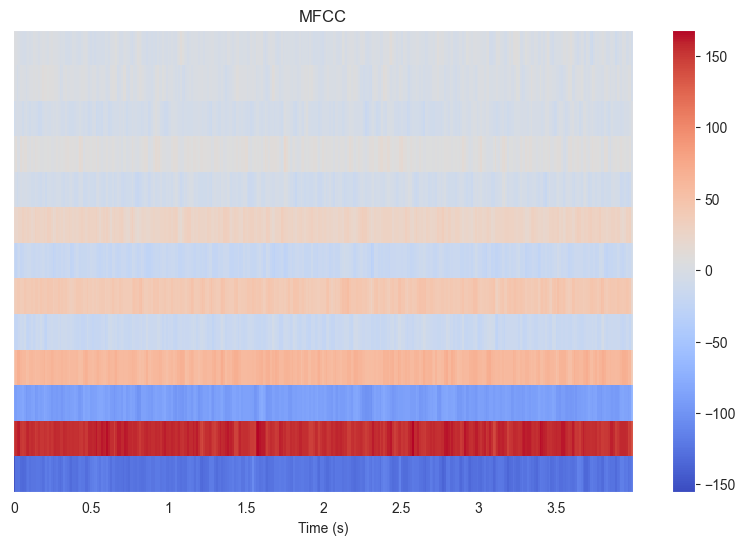

In [32]:
sample_mfccs = librosa.feature.mfcc(y=sample_y, sr=sr, n_mfcc=13)
print(f"MFCC shape for sample: {sample_mfccs.shape}" )

plt.figure(figsize=(10, 6))
librosa.display.specshow(sample_mfccs, x_axis="time", sr=sr)
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time (s)')
plt.show()

In [17]:
N_MFCC = 20

In [18]:
def extract_mfcc(audio_file, n_mfcc=N_MFCC):
    amplitudes, sr = librosa.load(audio_file, sr=None)
    mfcc = librosa.feature.mfcc(y=amplitudes, sr=sr, n_mfcc=n_mfcc)
    return mfcc

In [20]:
MAX_TIME_FRAMES_COUNT = 750 

In [21]:
def resize_audio_features(mfcc, max_time_frames_count=MAX_TIME_FRAMES_COUNT):
    n_frames = mfcc.shape[1]
    new_mfcc = []
    
    if n_frames < max_time_frames_count:
        pad_width = max_time_frames_count - n_frames
        new_mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        new_mfcc = mfcc[:, :max_time_frames_count]
        
    return new_mfcc

In [37]:
def load_audio_features(df, max_time_frames_count=MAX_TIME_FRAMES_COUNT):
    X = []
    y = []
    
    start_extraction_time = time.time()
    
    for idx, row in df.iterrows():
        mfcc = extract_mfcc(row["path_to_audio"])
        reshaped_mfcc = resize_audio_features(mfcc, max_time_frames_count)
        
        X.append(reshaped_mfcc)
        y.append(row["class"])
    
        if idx > 0 and idx % 500 == 0:
            print(f"Processing {idx}/{df.shape[0]}. Took time: {time.time() - start_extraction_time:.3f} (s)")
            
    return np.array(X), np.array(y)

In [38]:
X, y = load_audio_features(df)
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

Processing 500/8732. Took time: 6.063 (s)
Processing 1000/8732. Took time: 16.691 (s)
Processing 1500/8732. Took time: 26.554 (s)
Processing 2000/8732. Took time: 36.450 (s)
Processing 2500/8732. Took time: 44.089 (s)


C:\Data\University\master\master_2_year_sem_1\multimedia-data-processing\lab_1\.venv\lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 3000/8732. Took time: 51.829 (s)
Processing 3500/8732. Took time: 58.433 (s)
Processing 4000/8732. Took time: 65.485 (s)
Processing 4500/8732. Took time: 73.330 (s)
Processing 5000/8732. Took time: 80.765 (s)
Processing 5500/8732. Took time: 87.457 (s)
Processing 6000/8732. Took time: 93.647 (s)
Processing 6500/8732. Took time: 99.908 (s)
Processing 7000/8732. Took time: 107.434 (s)
Processing 7500/8732. Took time: 114.899 (s)
Processing 8000/8732. Took time: 122.492 (s)
Processing 8500/8732. Took time: 130.923 (s)
X.shape: (8732, 20, 750)
y.shape: (8732,)


In [6]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [7]:
LABELS_COUNT = len(np.unique(y))
LABELS_COUNT

10

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (6549, 20, 750)
y_train.shape: (6549,)
X_test.shape: (2183, 20, 750)
y_test.shape: (2183,)


In [42]:
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (6549, 1, 20, 750)
y_train.shape: (6549,)
X_test.shape: (2183, 1, 20, 750)
y_test.shape: (2183,)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
class AudioCNNClassifier(nn.Module):
    def __init__(self, labels_count=LABELS_COUNT, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.labels_count = labels_count
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 7), padding=(1, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 4)),
            
            nn.Conv2d(32, 64, kernel_size=(3, 5), padding=(1, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 4)),
            
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,4)),
            
            nn.Flatten(),
            nn.Linear(128 * 2 * 11, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, labels_count)
        )
        
    def forward(self, x):
        x = self.classifier(x)
        
        return x

In [45]:
n_epochs = 35
batch_size = 32
n_samples = X_train.shape[0]

In [42]:
def train(X_train=X_train, y_train=y_train):
    model = AudioCNNClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    print(f"Start training CNN")
    train_start_time = time.time()
    
    for epoch in range(n_epochs):
        print(f'Start training epoch {epoch}/{n_epochs}')
    
        epoch_start_time = time.time()
    
        model.train()
        epoch_loss = 0
    
        n_correct_predictions = 0
        n_total_predictions = 0
    
        indices = torch.randperm(n_samples)
    
        for batch_idx in range(0, n_samples, batch_size):
            items_idx = indices[batch_idx:batch_idx + batch_size]
            X_train_batch = torch.tensor(X_train[items_idx], dtype=torch.float32).to(device)
            y_train_batch = torch.tensor(y_train[items_idx], dtype=torch.long).to(device)
    
            optimizer.zero_grad()
            outputs = model(X_train_batch)
            loss = criterion(outputs, y_train_batch)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
    
            _, predictions = torch.max(outputs, dim=1)
            n_correct_predictions += (predictions == y_train_batch).sum().item()
            n_total_predictions += y_train_batch.size(0)
    
        print(f"Finish training epoch {epoch}/{n_epochs}."
              f" Loss: {epoch_loss:.4f}."
              f" Accuracy: {n_correct_predictions / n_total_predictions * 100:.4f}."
              f" Time elapsed: {time.time() - epoch_start_time:.2f} (s)"
        )
    
    print(f"Finish training model. Time elapsed: {time.time() - train_start_time:.2f} (s)")
    
    return model

NameError: name 'X_train' is not defined

In [9]:
OUTPUT_MODEL_PATH = os.path.join(".", "output_models")

In [ ]:
# model = train(X_train, y_train)

model = AudioCNNClassifier().to(device)
model.load_state_dict(torch.load(os.path.join(OUTPUT_MODEL_PATH, "model.pt")))

In [50]:
os.makedirs(OUTPUT_MODEL_PATH, exist_ok=True)
torch.save(model.state_dict(), os.path.join(OUTPUT_MODEL_PATH, "model.pt"))

In [71]:
model.eval()

predictions = []

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    outputs = model(X_test_tensor)
    _, preds = torch.max(outputs, 1)
    predictions = preds.cpu().numpy()
    
cm = confusion_matrix(
    label_encoder.inverse_transform(y_test),
    label_encoder.inverse_transform(predictions)
)
print(cm)

[[245   0   0   0   1   0   0   1   1   2]
 [  0  93   1   1   6   1   1   0   0   4]
 [  0   0 207   4   2   1   0   0   3  33]
 [  1   1   9 226   4   0   3   0   1   5]
 [  0   0   0   1 244   1   0   1   0   3]
 [  2   1   2   2   2 237   0   0   1   3]
 [  0   1   0   0   1   0  92   0   0   0]
 [  0   1   0   0  16   0   0 229   0   4]
 [  1   0   8   0   1   0   0   0 217   5]
 [  0   0  10   2   1   1   0   1   3 232]]


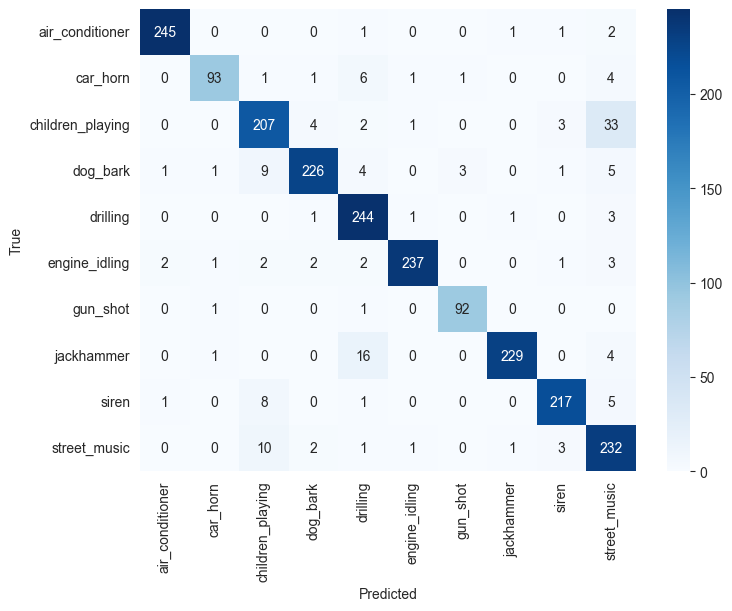

In [73]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [76]:
print(classification_report(label_encoder.inverse_transform(y_test),label_encoder.inverse_transform(predictions)))

                  precision    recall  f1-score   support

 air_conditioner       0.98      0.98      0.98       250
        car_horn       0.96      0.87      0.91       107
children_playing       0.87      0.83      0.85       250
        dog_bark       0.96      0.90      0.93       250
        drilling       0.88      0.98      0.92       250
   engine_idling       0.98      0.95      0.97       250
        gun_shot       0.96      0.98      0.97        94
      jackhammer       0.99      0.92      0.95       250
           siren       0.96      0.94      0.95       232
    street_music       0.80      0.93      0.86       250

        accuracy                           0.93      2183
       macro avg       0.93      0.93      0.93      2183
    weighted avg       0.93      0.93      0.93      2183



In [43]:
def infer(model, path_to_audio):
    mfcc = extract_mfcc(path_to_audio)
    resized_mfcc = resize_audio_features(mfcc)
    X_input = torch.tensor(resized_mfcc[np.newaxis, np.newaxis, :, :], dtype=torch.float32).to(device)

    model.eval()
    
    with torch.no_grad():
        outputs = model(X_input)
        _, preds = torch.max(outputs, 1)
        predictions = preds.cpu().numpy()
        
    return predictions

In [44]:
label_encoder.inverse_transform(infer(model, os.path.join(".", "inference_test", "children_playing.wav")))

array(['children_playing'], dtype='<U16')

In [45]:
label_encoder.inverse_transform(infer(model, os.path.join(".", "inference_test", "gun_fire.wav")))

array(['gun_shot'], dtype='<U16')

In [46]:
label_encoder.inverse_transform(infer(model, os.path.join(".", "inference_test", "jackhammer.wav")))

array(['jackhammer'], dtype='<U16')